In [23]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array

In [24]:
spark = SparkSession.builder \
    .appName("cource_work_fraud_detection") \
    .master("spark://localhost:7077") \
    .config('deploy-mode', 'cluster') \
    .config('spark.executor.memory', '20g') \
    .getOrCreate()



In [4]:
spark.stop()

In [ ]:
file_path = "file:///opt/spark/data/creditcard.csv"
credit_card_df = spark.read.csv(file_path, header=True, inferSchema=True)


In [4]:

print(f"class 1 number: {credit_card_df.where(credit_card_df.Class == 1).count()}")
print(f"class 0 number: {credit_card_df.where(credit_card_df.Class == 0).count()}")



class 1 number: 492
class 0 number: 284315


Візуалізація датасету. Confusion matrix і розподіл між двома класами.
Можемо бачити наступну картину: на Class є незначний вплив із V11, V4, V2.
На Ammount є вплив із V7, V20 та V6

25/01/06 09:30:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/01/06 09:30:03 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


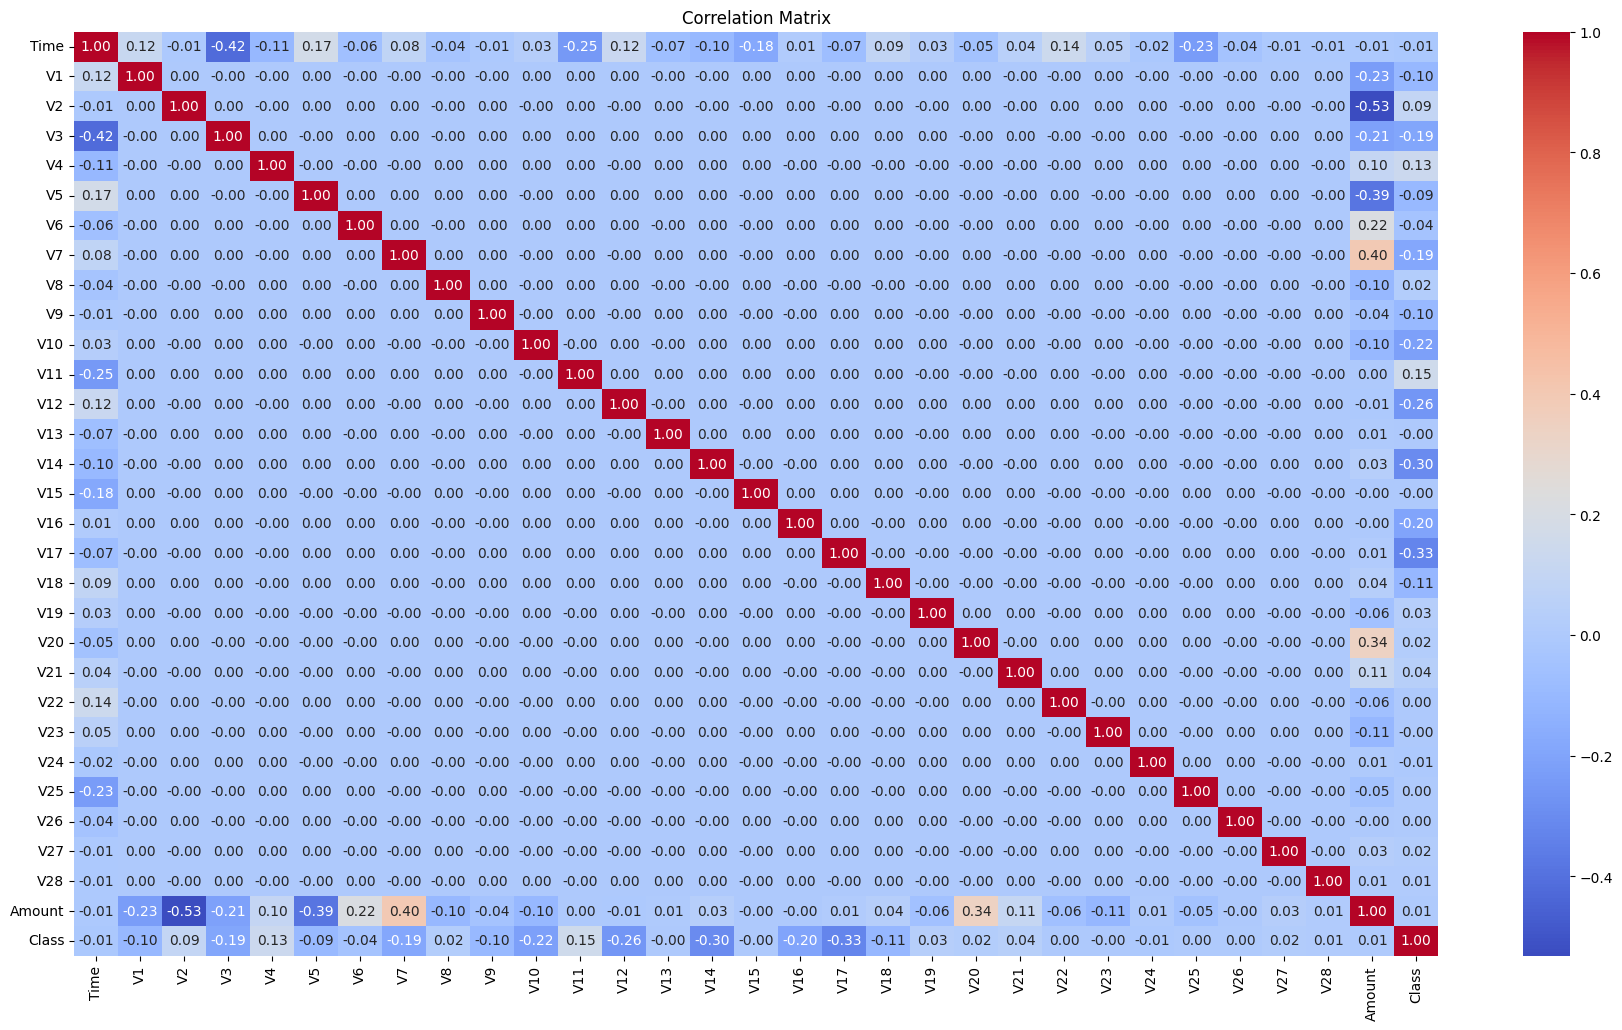

In [5]:
import seaborn as sns

# Перетворення в Pandas DataFrame для числових колонок
confusion_df = credit_card_df.toPandas()

# Обчислення кореляції
correlation_matrix = confusion_df.corr()

# Побудова heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()

Почнемо із найпростішого підходу, IQR (Interquartile Range) - вимірює розмах між 25-м та 75-м квартилями. Це допоможе визначити викиди в даних (потенційні шахрайські транзакції).
Важливо зазначити, що використання декількох фіч покращує результати.

In [9]:
# Descriptive statistics
credit_card_df.describe().show()

# For feature Ammoount
credit_card_df.select("Amount").describe().show()

features = ["Amount", "V11", "V4", "V2"]

outlier_conditions = []
for feature in features:
    # Compute IQR for each feature
    Q1 = credit_card_df.approxQuantile(feature, [0.25], 0)[0]
    Q3 = credit_card_df.approxQuantile(feature, [0.75], 0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Add condition for the current feature
    condition = (credit_card_df[feature] < lower_bound) | (credit_card_df[feature] > upper_bound)
    outlier_conditions.append(condition)

# Combine all outlier conditions
combined_outliers = outlier_conditions[0]
for condition in outlier_conditions[1:]:
    combined_outliers |= condition

# Filter outliers based on combined conditions
outliers = credit_card_df.where(combined_outliers)

# Analyze the outliers
outliers.select("Amount", "V11", "V4", "V2").describe().show()
outliers_df = outliers.select("Amount", "V11", "V4", "V2").where(outliers.Class == 1)

# Display results
print(f"Number of outliers: {outliers.count()}")
print(f"Number of outliers with Class 1: {outliers.where(outliers.Class == 1).count()}")



+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|  

Також використаємо Z-оцінку, яка вимірює, наскільки далеко від середнього значення знаходиться точка даних. Це допоможе визначити викиди в даних.

In [7]:
from pyspark.sql import functions as F

mean_amount = credit_card_df.select("Amount").agg({"Amount": "mean"}).collect()[0][0]
stddev_amount = credit_card_df.select("Amount").agg({"Amount": "stddev"}).collect()[0][0]

# Calculate Z-score for Amount
credit_card_df = credit_card_df.withColumn('zscore_Amount', 
                                           (F.col('Amount') - mean_amount) / stddev_amount)


# Flaging fraud operations
credit_card_df = credit_card_df.withColumn('is_fraud', F.when(F.abs(F.col('zscore_Amount')) > 0.35, 1).otherwise(0))

# Number of fraud operations
print(credit_card_df.where(credit_card_df.is_fraud == 1).count())

# Number of fraud operations with Class 1 and predicted as fraud
z_score_df = credit_card_df.where((credit_card_df.is_fraud == 1) & (credit_card_df.Class == 1))
print(z_score_df.count())

42480
159


Додатково, проаналізуємо, саме набір шахрайських транзакцій, щоб зрозуміти, як вони відрізняються від нормальних транзакцій.

In [8]:
fraud_df = credit_card_df.where(credit_card_df.Class == 1)

non_fraud_df = credit_card_df.where(credit_card_df.Class == 0)

fraud_df.select("Amount", "Class", "Time", "V11", "V4", "V2").describe().show()  

non_fraud_df.select("Amount", "Class", "Time", "V11", "V4", "V2").describe().show()




+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+
|summary|           Amount|Class|             Time|               V11|                V4|               V2|
+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+
|  count|              492|  492|              492|               492|               492|              492|
|   mean|122.2113211382114|  1.0|80746.80691056911|3.8001729113746077| 4.542029104423093|3.623778101982281|
| stddev|256.6832882977121|  0.0|47835.36513767505| 2.678604522510197|2.8733176878992315| 4.29121562613748|
|    min|              0.0|    1|            406.0| -1.70222840135659| -1.31327481447103|-8.40215367768915|
|    max|          2125.87|    1|         170348.0|  12.0189131816199|  12.1146718424589| 22.0577289904909|
+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+

+-------+------------------

25/01/05 15:18:49 ERROR TaskSchedulerImpl: Lost executor 0 on 172.21.0.8: worker lost: 172.21.0.8:39669 got disassociated
25/01/05 15:18:49 WARN TransportChannelHandler: Exception in connection from /172.21.0.8:49482
java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:401)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:434)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.ja

Amount    402
V11       402
V4        402
V2        402
dtype: int64
Amount    492
V11       492
V4        492
V2        492
dtype: int64


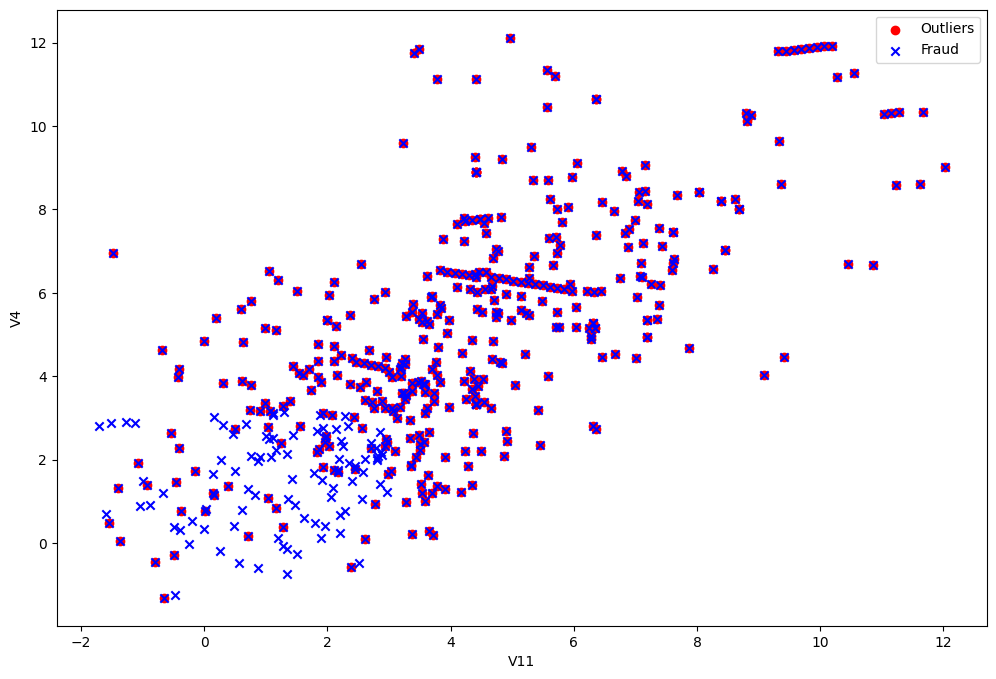

25/01/06 11:29:54 ERROR TaskSchedulerImpl: Lost executor 0 on 172.21.0.8: worker lost: 172.21.0.8:34273 got disassociated
25/01/06 11:29:54 WARN TransportChannelHandler: Exception in connection from /172.21.0.8:57810
java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:401)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:434)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.ja

In [22]:
# Visulaize the output of IQR method and real fraud operations

# Convert to Pandas DataFrame
outliers_pd = outliers_df.toPandas()
print(outliers_pd.count())
fraud_pd = credit_card_df.select("Amount", "V11", "V4", "V2").where(credit_card_df.Class == 1).toPandas()
print(fraud_pd.count())
# Plot the data
plt.figure(figsize=(12, 8))
# we need to plot this data . with diff markers
plt.scatter(outliers_pd['V11'], outliers_pd['V4'], color='red', label='Outliers', marker='o')
plt.scatter(fraud_pd['V11'], fraud_pd['V4'], color='blue', label='Fraud', marker='x')
plt.xlabel('V11')
plt.ylabel('V4')
plt.legend()
